What we need is a small parcel to work on, with a nice contourplot with critical points and minima found after initiating local method and then a 3d plot. 

In [ ]:
using Pkg
Pkg.activate("../../.")
using CairoMakie
CairoMakie.activate!()
using Globtim
using DynamicPolynomials, DataFrames

In [2]:
# Constants and Parameters
const n, a, b = 2, 5, 12
const scale_factor = a / b   # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = 0.5, 1 / 10  # Sampling parameters
const tol_l2 = 3e-4            # Define the tolerance for the L2-norm
f = tref # Objective function

tref (generic function with 1 method)

One may assume that when we have access to exact evaluations, we would want to have a small $L^2$-norm tolerance `tol_l2 = 5e-4` and high probability of computing an accurate discrete $L^2$-norm `alpha= 1/10`.

We need to also return the number of samples used to generate the sample set. It is annoying that the error goes up while the degree has increased.

In [3]:
# rand_center = [2*rand()-1, 2*rand()-1]*.75; # Random center
# rand_center = [0.4694712315165298, -0.45637754560934185]
rand_center = [0.0, 0.0];

In [4]:
d = 10 # Initial Degree 
SMPL = 100 # Number of samples
TR = test_input(f, 
                dim = n,
                center=rand_center,
                GN=SMPL, 
                sample_range=scale_factor, 
                degree_max = d+4
                )
pol_cheb = Constructor(TR, d, basis=:chebyshev)
pol_lege = Constructor(TR, d, basis=:legendre);

@polyvar(x[1:n]); # Define polynomial ring 

current L2-norm: 2.9850579087292233
current L2-norm: 2.9788137736972087


Solve the system of partial derivatives using `Msolve`. For degree `26` on tref centered at `rand_center = [0.4694712315165298, -0.45637754560934185]` and `a/b = 7//12`, `msolve runs single threaded in 5m 2.2 s. With 10 threads, it runs in 4m 48.2 s. 
The slow part of the process is the real root isolation it would seem. 

In [5]:
df_cheb = solve_and_parse(pol_cheb, x, f, TR)
sort!(df_cheb, :z, rev=true)


=== Starting MSolve Parser (dimension: 2) ===
Processed 43 points (0.0s)


Row,x1,x2,z
,Float64,Float64,Float64
1,-0.330146,-0.406511,3.63871
2,0.210748,0.262433,3.56428
3,-0.05833,-0.124611,3.49624
4,-0.0986648,-0.0241965,3.12104
5,0.167232,-0.26429,2.6438
6,-0.331586,0.220752,2.45281
7,-0.210856,0.0335872,2.29801
8,0.333534,0.176992,2.03699
9,-0.416039,-0.272693,1.85874


Legendre polynomial: 8m49 s, `scale_factor = 1/3` and degree `30`, and 300 sample points.  

In [6]:
# df_lege = solve_and_parse(pol_lege, x, f, TR, basis=:legendre)
# sort!(df_lege, :z, rev=true)

In [7]:
using Optim
df_cheb, df_min_cheb = analyze_critical_points(f, df_cheb, TR, tol_dist=0.01)

Processing point 1 of 29
Optimization has converged: ✓
Processing point 2 of 29
Optimization has converged: ✓
Processing point 3 of 29
Optimization has converged: ✓
Processing point 4 of 29
Optimization has converged: ✓
Processing point 5 of 29
Optimization has converged: ✓
Processing point 6 of 29
Optimization has converged: ✓
Processing point 7 of 29
Optimization has converged: ✓
Processing point 8 of 29
Optimization has converged: ✓
Processing point 9 of 29
Optimization has converged: ✓
Processing point 10 of 29
Optimization has converged: ✓
Processing point 11 of 29
Optimization has converged: ✓
Processing point 12 of 29
Optimization has converged: ✓
Processing point 13 of 29
Optimization has converged: ✓
Processing point 14 of 29
Optimization has converged: ✓
Processing point 15 of 29
Optimization has converged: ✓
Processing point 16 of 29
Optimization has converged: ✓
Processing point 17 of 29
Optimization has converged: ✓
Processing point 18 of 29
Optimization has converged: ✓
P

(29×8 DataFrame
 Row │ x1          x2          z          y1          y2          close  steps ⋯
     │ Float64     Float64     Float64    Float64     Float64     Bool   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.330146   -0.406511    3.63871    0.748998   -0.338998   false      8 ⋯
   2 │  0.210748    0.262433    3.56428    0.747945    2.10962    false      9
   3 │ -0.05833    -0.124611    3.49624   -0.0222934   0.0472676  false     11
   4 │ -0.0986648  -0.0241965   3.12104   -0.504568    0.0451983  false     13
   5 │  0.167232   -0.26429     2.6438    -0.393609    2.19474    false      8 ⋯
   6 │ -0.331586    0.220752    2.45281    0.751676   -1.27267    false      8
   7 │ -0.210856    0.0335872   2.29801    4.12078     0.993458   false      7
   8 │  0.333534    0.176992    2.03699    0.449094    0.291443   false      7
  ⋮  │     ⋮           ⋮           ⋮          ⋮           ⋮         ⋮       ⋮  ⋱
  23 │ -0.0110115  -0.40

In [16]:
using GLMakie
GLMakie.activate!(inline=false)

In [9]:
# df_cheb, df_min_cheb = analyze_critical_points(f, df_cheb, TR)
# df_lege, df_min_lege = analyze_critical_points(f, df_lege, TR)

In [17]:
plot_polyapprox_rotate(pol_cheb, TR, df_cheb, df_min_cheb)

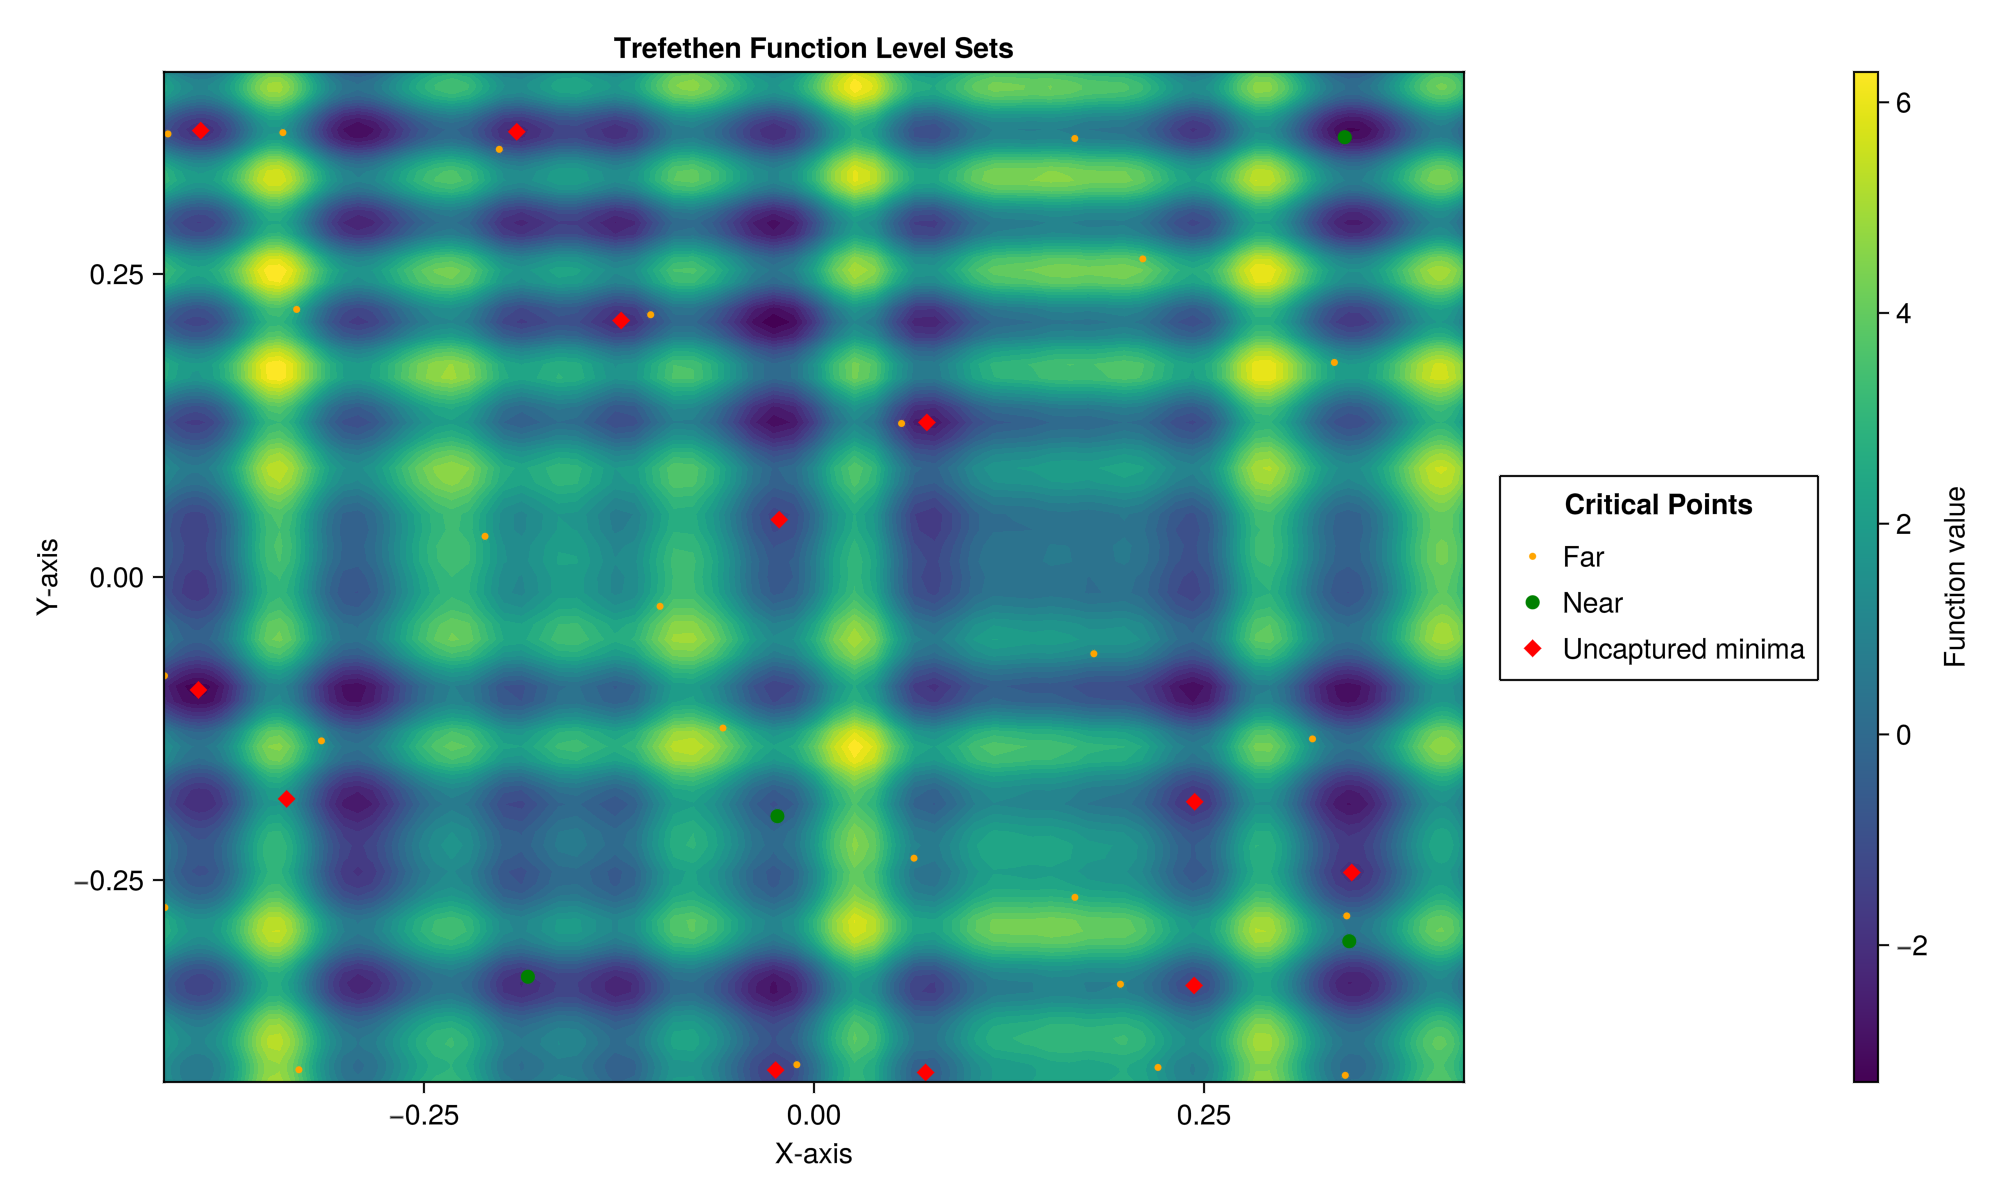

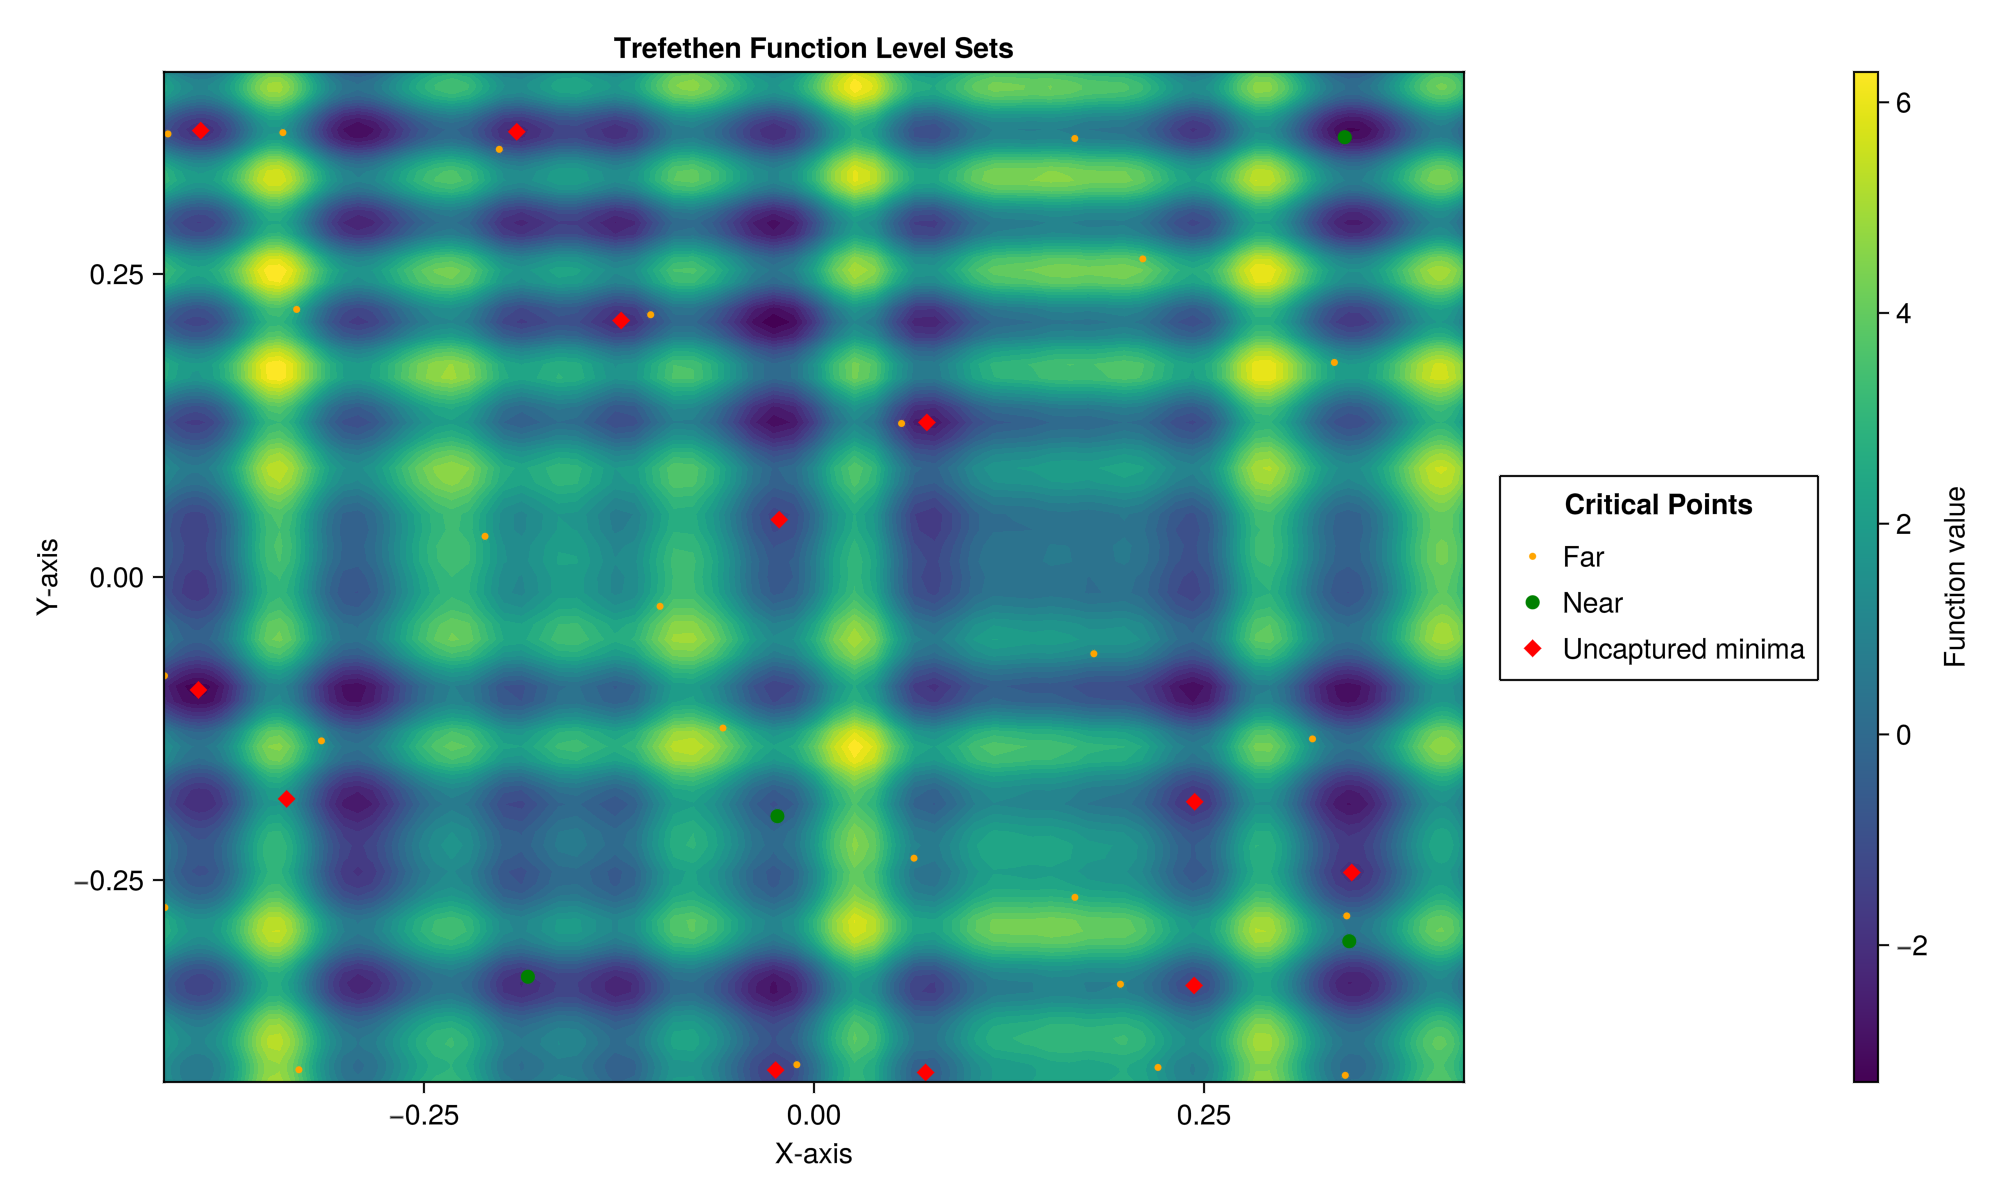

In [11]:
fig1 = plot_polyapprox_levelset(pol_cheb, TR, df_cheb, df_min_cheb)

In [13]:
# plot_polyapprox_levelset(pol_cheb, TR, df_cheb, df_min_cheb)

In [14]:
# plot_polyapprox_levelset(pol_lege, TR, df_lege, df_min_lege)

In [15]:
# GLMakie.closeall()

The trefethen example: 
Is about the 100 digit challenge, which goal was to compute the global minimizer of the `tref` function over the domain $[-1,1]^2$ and to refine the accuracy of that minimizer up to a 100 digits.
This function has ... many local minimizers in the interior of that domain. 
With `Globtim`, we attempt to approach all critical points.
To keep the degree of the approximant reasonable, we subdivide the domain into smaller squares and apply `Globtim` to each of them.

How do we measure the discrete error: Riemman sum, discrete $L^2$-norm, or the maximum error?
--> we verify the error on a separately generated uniform grid of $N = $ points.

We refine the candidate local minimizers we computed with msolve through a local optimization method in the `Optim` package in Julia. 
